# <div style="padding:20px;color:white;margin:0;font-size:50px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#000850;overflow:hidden"><b>Correcting Document Rotation</b></div>

<h5 style="text-align: center; font-family: Verdana; font-size: 12px; font-style: normal; font-weight: bold; text-decoration: None; text-transform: none; letter-spacing: 1px; color: #254E58; background-color: #ffffff;">Mikołaj Pawlak</h5>

<h5 style="text-align: center;padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#000850;overflow:hidden">The task is to find out how much the document is rotated based on text rotation. For this purpose, in this notebook two methods are presented - Hough Lines and Pytesseract OCR.</h5>


<br>    
<p style="text-align: center;">
<img src="rotate_illustration.png" style='width: 400px; height: 250px;'> 
<details> Source: https://www.adobe.com/dc-shared/assets/images/frictionless/how-to-images/rotate-pdf-how-to.svg
</details> 
</p>

<a id="top"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#000814;overflow:hidden"><b>Table of content</b></div>

<div style="background-color:#FCFBF4; padding:30px; font-size:15px;color:#034914">

1. [Import libraries, define functions, gett the image](#1)
    
2. [Preprocessing](#2) 
    
3. [Method 1 - Hough lines](#3) 
    
4. [Method 2 - Pytesseract](#4)
    
5. [Rotate the image](#5)
</div>

<a id="1"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#000814;overflow:hidden"> 1. Import libraries, define functions, get the image</div>

In [1]:
import cv2
import numpy as np
import pytesseract
import math
from matplotlib import pyplot as plt
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe' # Your path to tesseract.exe in Program Files
# download from here https://github.com/UB-Mannheim/tesseract/wiki
# pip install pytesseract
# set path as above
# https://stackoverflow.com/questions/50951955/pytesseract-tesseractnotfound-error-tesseract-is-not-installed-or-its-not-i
from pytesseract import Output

In [2]:
def imshow(titles=None, images=None, size=5):
    '''This function plots 1 or more images read by OpenCV'''
    # If titles and images are not lists, convert them to lists
    if not isinstance(titles, list):
        titles = [titles]
    if not isinstance(images, list):
        images = [images]

    num_images = len(images)

    # Create a subplot with the desired number of columns
    fig, axes = plt.subplots(1, num_images, figsize=(size * num_images, size))

    # Ensure axes is always treated as a list
    if num_images == 1:
        axes = [axes]

    # Iterate through titles and images to display them
    for i in range(num_images):
        w, h = images[i].shape[0], images[i].shape[1]
        aspect_ratio = w / h
        axes[i].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        axes[i].set_title(titles[i])
       # axes[i].axis('off')  # Turn off axis labels

    plt.show()

In [3]:
# Read the image
image_original = cv2.imread('rotated_document.png')

<center> <a href="#top" role="button" aria-pressed="true" > 🚀 Return to the Beginning 🚀</a>

<a id="2"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#000814;overflow:hidden"> 2. Preprocessing</div> 

In [4]:
# Convert the image to grayscale
image_gray = cv2.cvtColor(image_original, cv2.COLOR_BGR2GRAY)
# Apply blur - Gaussian works better in this case
# image = cv2.medianBlur(image, 3)
image_blur = cv2.GaussianBlur(image_gray, (7,7), 0)
# Add threshold
image_gaussian = cv2.adaptiveThreshold(image_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
image_otsu = cv2.threshold(image_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

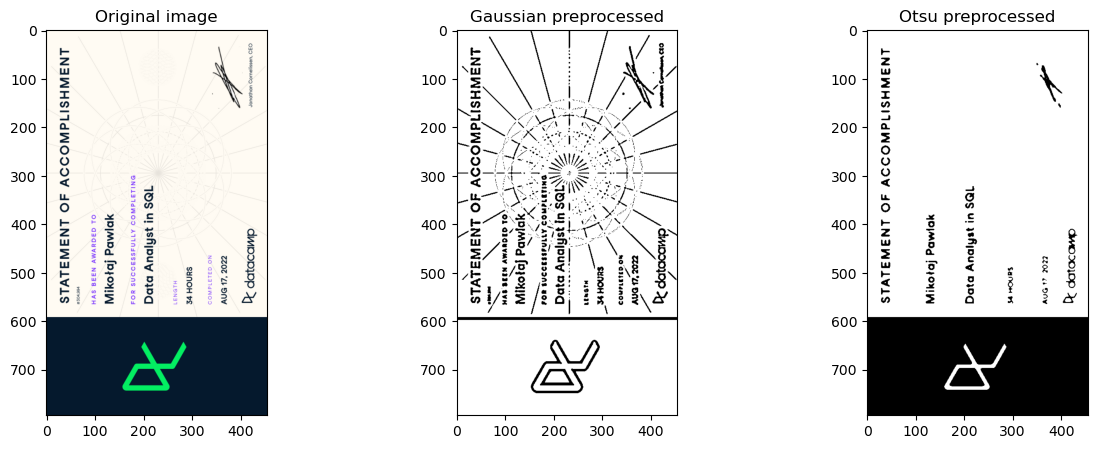

In [5]:
imshow(['Original image', 'Gaussian preprocessed', 'Otsu preprocessed'],[image_original, image_gaussian, image_otsu], size=5)

Otsu version looks better as it clears the decoration lines from the image, leaving the text wide open.

In [6]:
image = image_otsu

Skip steps such as kernel and dilation because they obscure the text in this particular image.

In [7]:
# kernal = cv2.getStructuringElement(cv2.MORPH_GRADIENT , (1,1))
# dilate = cv2.dilate(thresh, kernal, iterations=1)
# imshow('x', dilate)

<center> <a href="#top" role="button" aria-pressed="true" > 🚀 Return to the Beginning 🚀</a>

<a id="3"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#000814;overflow:hidden"> 3. Method 1 - Hough lines</div> 

The first method utilizes Hough lines, which are based on  <b> polar coordinates </b>.

In polar coordinates, a point in the plane is determined by its distance r from the origin and the angle theta (in radians) between the line from the origin to the point and the x-axis (see the figure below).

![Polar_coordinates.png](Polar_coordinates.png)

https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html  
https://sites.science.oregonstate.edu/math/home/programs/undergrad/CalculusQuestStudyGuides/vcalc/coord/coord.html
https://stackoverflow.com/questions/23783061/detect-text-orientation

In [8]:
# Lets try to make a bouding boxes with Tesseract OCR to see how the text should be captured
custom_config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789'
boxes = pytesseract.image_to_boxes(image, config=custom_config).splitlines()

# Extract coordinates of the bounding boxes
box_coordinates = [list(map(int, box.split()[1:5])) for box in boxes]

# Convert the coordinates to NumPy array for easier manipulation
box_coordinates = np.array(box_coordinates)

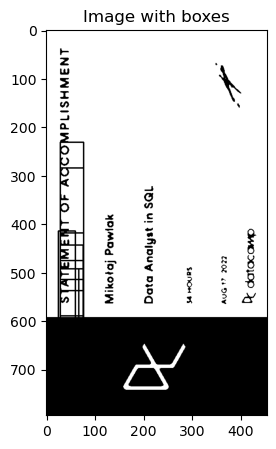

In [9]:
image_copy = image.copy()
# Draw bounding boxes on the image
for coordinates in box_coordinates:
    x, y, w, h = coordinates
    if h > 200 and w < 100:
        cv2.rectangle(image_copy, (x, y), (x+w, y+ h), (0, 255, 0), 2)


imshow('Image with boxes', image_copy)

In [11]:
# Apply Hough Line Transform to detect lines in the image
lines = cv2.HoughLines(image, 1, np.pi / 180, 100)

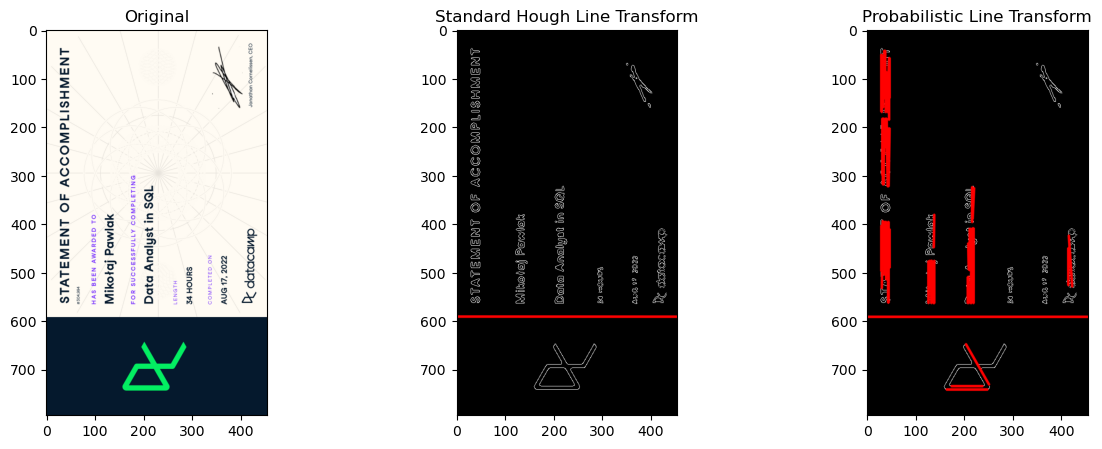

In [12]:
dst = cv2.Canny(image, 50, 200, None, 3)
    
# Copy edges to the images that will display the results in BGR
cdst = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)
cdstP = np.copy(cdst)

lines = cv2.HoughLines(dst, 1, np.pi / 180, 150, None, 0, 0)

if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(cdst, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)


linesP = cv2.HoughLinesP(dst, 1, np.pi / 180, 50, None, 50, 10)

if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv2.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)

imshow(["Original", "Standard Hough Line Transform", 'Probabilistic Line Transform'], [image_original, cdst, cdstP])

In [13]:
# This loop iterates over each line detected by the Hough Line Transform. 
# lines is a list of lines where each line is represented by a pair of values (rho, theta)
angles = []
for line in lines:
    rho, theta = line[0]
    angles.append(np.degrees(theta))

# Calculate the average angle of the detected lines
average_angle = np.mean(angles)

# Print the detected text orientation
print(f"Text Orientation: {average_angle} degrees")
print(angles)

Text Orientation: 90.0 degrees
[90.0]


<b> This method gives us the correct result. </b>

<center> <a href="#top" role="button" aria-pressed="true" > 🚀 Return to the Beginning 🚀</a>

<a id="4"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Helvecita;text-align:left;display:fill;border-radius:5px;background-color:#000814;overflow:hidden"> 4. Method 2 - Pytesseract</div> 

In [14]:
# Read the image
image_original = cv2.imread('rotated_document.png')

In [18]:
rgb = cv2.cvtColor(image_original, cv2.COLOR_BGR2RGB)
results = pytesseract.image_to_osd(rgb, output_type=Output.DICT)
# display the orientation information
print("[INFO] detected orientation: {}".format(
	results["orientation"]))
print("[INFO] rotate by {} degrees to correct".format(
	results["rotate"]))
# print("[INFO] detected script: {}".format(results["script"]))

[INFO] detected orientation: 270
[INFO] rotate by 90 degrees to correct


<b>This method also gives us the result we wanted. However, it's quicker and doesn't require that many lines of code. </b>

<center> <a href="#top" role="button" aria-pressed="true" > 🚀 Return to the Beginning 🚀</a>

<a id="5"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Helvecita;text-align:left;display:fill;border-radius:5px;background-color:#000814;overflow:hidden"> 5. Rotate the image</div> 

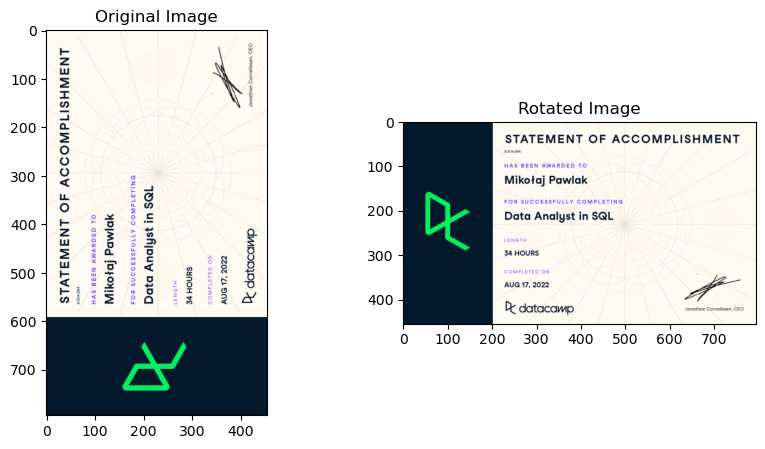

In [16]:
# Method 1
rotated_image = np.rot90(image_original, k=-1)
imshow(titles=['Original Image', 'Rotated Image'], images=[image_original, rotated_image], size=5)

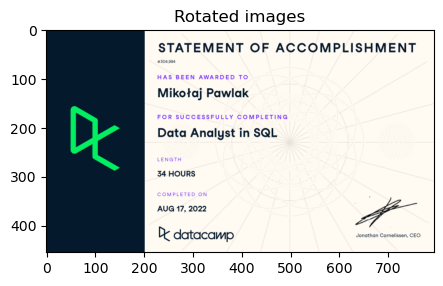

In [17]:
# Method 2
rotated_image2 = cv2.transpose(image_original)
rotated_image2 = cv2.flip(rotated_image2, 1)
imshow("Rotated images", rotated_image2)

https://medium.com/analytics-vidhya/how-to-auto-rotate-the-image-using-deep-learning-c34b2e0e157d

<center> <a href="#top" role="button" aria-pressed="true" > 🚀 Return to the Beginning 🚀</a>